# Week 6 Data Challenge: Confounded Cuisiner


### <b><u>The Goal</u></b>   
You've just joined the data team at an online publishing company. One of your verticals is a food publication. A product manager on your team wants to build a feature for this vertical that enables users to query by cuisine, not just by ingredients. All of your recipes are unlabeled, and it's infeasible to label them by hand.
Design and execute a method to group the recipes by cuisine. How could you design this to be robust enough to understand similarities / substitutions between ingredients? For each each major cuisine, what are the driving ingredients that characterize it?

Your product manager indicates a likelihood that you will only need to write a guideline for an outsourced team to hand label the remaining corpus. How would you go about writing this guide for a few major cuisines?

### <b><u>The Approach</b></u>   
This is an unsupervised learning problem where we have to:
 - Determine the number of clusters (cuisines) given the data.   
 - Determine the most common ingredients within the clusters and assess which ingredients are most characteristic of each cuisine.  
    
As in any clustering problem, we need to be able to caluclate distances between observations (recipes). This will be accomplished by applying TfidfVectorizer in order to convert the list of ingredients for a recipe into a set of numeric features. The Euclidean distance between the set of features for two recipes will serve as our distance metric.

To determine the appropriate number of clusters for this dataset, we will analyze how the number of clusters affects the average distance of each data point to its designated cluster. Once the correct number of clusters is known, one can simply look at the top ingredients used in recipes within each clusters to understand the driving ingredients that characterize it.

# Import libraries

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter

%matplotlib inline

# Import data

In [200]:
recipes = pd.read_json('data/unlabelled_recipies.json')
recipes.head(10)

,ingredients
0,"[pepper, bacon, russet potatoes, sugar, onions..."
1,"['rib', 'carrots', 'leeks', 'unsalted butter',..."
10,"[orzo, garlic, heavy cream, white wine, spinac..."
100,"['garlic', 'ginger', 'fish sauce', 'chayotes',..."
1000,"[onions, avocado, salt, coconut cream, cumin s..."
10000,"[salt, onion salt, paprika, ground cumin, dice..."
10001,"[fennel seeds, sugar cane juice, ice, thai bas..."
10002,"[hot water, part-skim ricotta cheese, provolon..."
10003,"[lemon juice, salt, egg whites, milk, egg yolk..."
10004,"['sambal ulek', 'brown sugar', 'peeled fresh g..."


In [61]:
print('The number of recipes is {}'.format(recipes.shape[0]))

The number of recipes is 39774


# Data clean-up

## "Ingredients" column type

One of the weird things in this dataset is that it appears that some ingredients in recipes are given as strings while others as given as lists. Let's check to see if this is true.

In [70]:
type(recipes.loc[0, 'ingredients']), type(recipes.loc[1, 'ingredients'])

(list, str)

In order to clean this up, we can first cast the ingredient column as a string and then apply literal_eval, which can convert a string that contains a list into a list.

In [201]:
recipes['ingredients'] = recipes['ingredients'].astype(str).apply(literal_eval)

In [312]:
print('The number of duplicate recipes in the data is {}'.format(len(recipes[recipes['ingredients'].str.join(' ').duplicated()])))

The number of duplicate recipes in the data is 20


No need to remove duplicates since the number of duplicates is so low.

## Non-ingredients in ingredients list

From the head of the dataframe, it's clear that some ingredients contain infromation that we wouldn't traditionally consider actual ingredients. For example "**ground** cumin", "**peeled fresh** garlic", or "egg **whites**". The parts in bold contain information about how the ingredient is prepared or descriptors of the ingredient, but not about the ingredient itself. Let's compare how many unique ingredients (containing this extra information) there are in the dataframe to the number of unique words.

In [73]:
ingredients = recipes['ingredients'].str.join(' ') # make single string out of ingredients
ingredient_cv = CountVectorizer()
ingredient_counts = ingredient_cv.fit_transform(ingredients)
print('Number of ingredients is {}.'.format(ingredient_counts.shape[1]))

Number of ingredients is 3010.


In [97]:
ingredients = recipes['ingredients'].str.join('_') # make single string out of ingredients but separate ingredients by "_", which we will use to tokenize
ingredient_cv = CountVectorizer(tokenizer = lambda x: x.split('_')) # split on "_" 
ingredient_counts = ingredient_cv.fit_transform(ingredients)
print('Number of ingredients is {}.'.format(ingredient_counts.shape[1]))

Number of ingredients is 6703.


There are ~6700 unique "ingredients" (ingredients like **chopped** chicken would be considered different than chicken) that can be composed of ~3000 unique words.

## Removing some non-ingredients ingredients AND common ingredients

One thing that may be helpful in our analysis is to remove commonly utilized non-ingredient ingredients, possibly words like **chopped** and **grated**. Furthermore, it may be useful to get rid of ingredients that are common across the majority of the recipes, e.g. **water**. To do this, we need to have a list of the most common words across all recipes.

First, let's clean up the ingredient lists a bit more by removing any digits (which would arise from the quantity of ingredient), punctuation (for example **oz.**), and any extra spaces.

In [394]:
def clean_ingredient_lists(series):
    res = series.str.join(' ')
    res = res.str.replace('\d', '') # remove digits
    res = res.str.replace('[~!@#$/.\%^&*\(\)_"\']', '') # remove punctuation
    res = res.str.replace('\s{1,10}', ' ') # remove extra spaces

In [395]:
ingredients = clean_ingredient_lists(recipes['ingredients'])

Now we can use CountVectorizer to get the number of times an ingredient is mentioned in each recipe.

In [212]:
ingredient_cv = CountVectorizer(stop_words='english')
ingredient_counts = ingredient_cv.fit_transform(ingredients)
ingredient_counts

<39774x2957 sparse matrix of type '<class 'numpy.int64'>'
	with 751131 stored elements in Compressed Sparse Row format>

In order to determine the top ingredients within the CSR matrix, we need to convert the CSR matrix to a dataframe and sum over all recipes for each ingredient.

In [213]:
recipes_cv = pd.DataFrame(ingredient_counts.toarray(), columns=ingredient_cv.get_feature_names())

In [214]:
top_ingredients = recipes_cv.sum().sort_values(ascending=False)
total_recipes = recipes.shape[0]
total_ingredients = 3010
top_ingredients_fraction = top_ingredients / total_recipes

It would be nice to know how many recipes incorporate the top n ingredients. To visualize this, we can plot the fraction of ingredients that show up in at least a certain fraction of recipes. We do this below for fraction of recipes ranging from 0 to 1 in divisions of 0.01.

In [174]:
fraction_of_recipes = np.arange(0,1,0.01)

counts = []
for recipe_fraction in fraction_of_recipes:
    count = 0
    for ingredient_fraction in top_ingredients_fraction:
        if ingredient_fraction > recipe_fraction:
            count += 1
    counts.append(count/total_ingredients * 100)

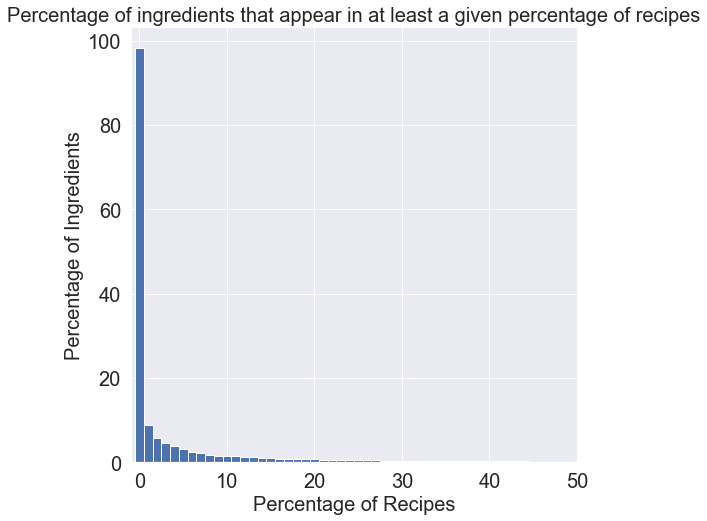

In [480]:
sns.set()
plt.figure(figsize=(8,8))
plt.bar(fraction_of_recipes*100, counts, width= 1)
plt.xlim(-1,50)
plt.xlabel('Percentage of Recipes', fontsize=20)
plt.ylabel('Percentage of Ingredients', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Percentage of ingredients that appear in at least a given percentage of recipes', fontsize=20);
plt.savefig('IngredientDistribution.png', dpi=300, bbox_inches='tight')

The figure shows that the larget majority of ingredients are not common across many recipes. In fact, a deeper dive into the data will show that over ~1500 ingredients are present in less than 10 recipes.

What are the top 20 ingredients?

In [225]:
print(top_ingredients[0:20])

pepper      25742
salt        24462
oil         23344
garlic      18941
ground      18271
fresh       17853
sauce       13129
sugar       12493
onions      12341
cheese      11776
chicken     11471
olive       10920
black       10753
water        9790
red          9189
flour        8851
butter       8648
tomatoes     8599
green        8531
powder       8290
dtype: int64


As expected, ingredients like **pepper, salt, water** are common across many recipes (note that there are approximately 40,000 recipes in our dataset). I've taken the liberty to go through the top 200 ingredients and subjectively select words that I thought should not belong in the ingredients list. This list is shown below.

In [229]:
remove_words = ['pepper', 'salt', 'oil', 'ground', 'fresh', 'black', 'water', 'red', 'green', 'powder', 
               'chopped', 'white', 'vegetable', 'leaves', 'large', 'dried', 'purpose', 'bell', 'grated',
               'extra', 'brown', 'unsalted', 'paste', 'fat', 'shredded', 'cooking', 'virgin', 'diced',
               'low', 'sodium', 'breasts', 'minced', 'spray', 'crushed', 'purple', 'light']

It might be beneficial to also remove ingredients that appear a very small fraction of the time, let's say less than 0.5% of the time. How many words are present in less than 0.5% of the recipes (~200 recipes)? The assumption here is that these words are not important to the classification of the cuisines.

In [230]:
print('Number of ingredients appearing in less than 0.5% of the recipes is {}.'.format(
    len(top_ingredients[top_ingredients < 0.005*recipes.shape[0]])))

Number of ingredients appearing in less than 0.5% of the recipes is 2540.


In [231]:
remove_words += top_ingredients[top_ingredients < 0.005*recipes.shape[0]].keys().tolist()

In [237]:
print('The number of ingredients in remove_words is {}.'.format(len(remove_words)))

The number of ingredients in remove_words is 2576.


Let's add the list of words to the list of English stop words within sklearn, which we will use to remove these ingredients when we perform our next analysis.

In [218]:
stop_words = text.ENGLISH_STOP_WORDS.union(remove_words)

# Clustering using K-means and Binary TfidfVectorizer

Now that we have a way to clean our data, we can continue on and try to cluster our data using K-means. We will fit a binary TfidfVectorizer using our composed list of stop words.

Why Tf-idf and why binary Tf-Idf? Compared to a CountVectorizer, Tf-Idf gives us a way of reducing the importance of ingredients that are common across many recipes (i.e. not *unique* to a cuisine). Since we only care if the recipe contains the ingredient and not the quantity, binarizing the term frequency is natural.

## Fit TfidfVectorizer and analyze top ingredients

In [339]:
ingredient_tfidf = TfidfVectorizer(stop_words=stop_words, binary=True)
ingredient_counts = ingredient_tfidf.fit_transform(ingredients)

To analyze the top ingredients shared amongst recipes, we'll have to convert ingredient_counts (a CSR matrix) into a pandas dataframe. We then can sum the values for each ingredient (columns) across all recipes (rows).

In [340]:
ingredient_counts_tfidf_df = pd.DataFrame(ingredient_counts.toarray(), columns=ingredient_tfidf.get_feature_names())
top_ingredients = ingredient_counts_tfidf_df.sum().sort_values(ascending=False)

In [483]:
ingredient_counts_tfidf_df.shape[1]

381

In [20]:
top_ingredients[:20]

garlic      2429.682711
sugar       2057.637255
onions      1947.584624
olive       1928.916969
sauce       1790.449594
butter      1740.130492
flour       1739.857595
cheese      1728.283536
chicken     1652.980721
tomatoes    1583.916805
eggs        1468.269570
cloves      1435.653269
juice       1413.114774
onion       1338.298725
milk        1308.759746
cream       1219.501661
rice        1207.660793
lemon       1199.305368
cilantro    1194.939688
vinegar     1129.220592
dtype: float64

## Clustering using K-means

One of the most difficult parts of this data challenge is to estimate how many different cuisines there are in the data set, which will influence the number of clusters we use in our analysis. In order to decide this, lets fit a k-means clustering model with variable clusters and see how this effects the average distance between each data point and the cluster it belongs to.

In [58]:
inertia = []
for n_clusters in range(1,31):
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42, n_init=1)
    kmeans.fit(df)
    inertia.append(kmeans.inertia_)

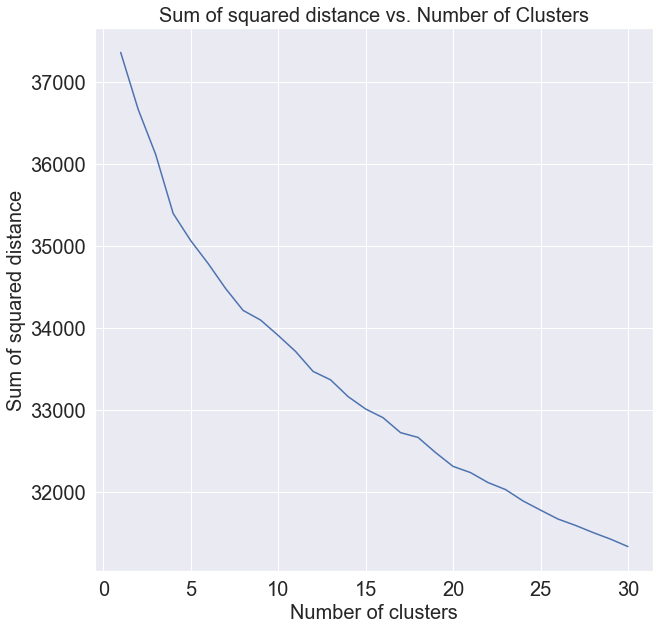

In [385]:
sns.set()
plt.figure(figsize=(10,10))
plt.plot(range(1,31), inertia)
plt.xlabel('Number of clusters', fontsize=20)
plt.ylabel('Sum of squared distance', fontsize=20)
plt.title('Sum of squared distance vs. Number of Clusters', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('ClusterNumberError.png', dpi=300, bbox_inches='tight')

In the plot above, we are looking for the "elbow," the point at which the slope changes from a large magnitude to a low magnitude. The elbow is not apparent in the figure, so let's try plotting the slope (gradient) of this curve instead.

In [320]:
gradient = []
for index in range(1,len(inertia)):
    gradient.append((inertia[index]-inertia[index-1]))

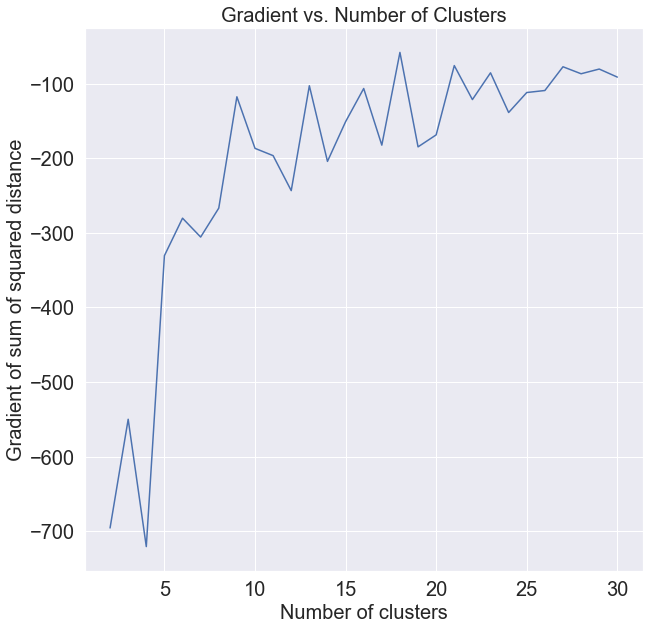

In [386]:
plt.figure(figsize=(10,10))
plt.plot(range(2,31), gradient)
plt.xlabel('Number of clusters', fontsize=20)
plt.ylabel('Gradient of sum of squared distance', fontsize=20)
plt.title('Gradient vs. Number of Clusters', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('ClusterNumberGradient.png', dpi=300, bbox_inches='tight')

Although the gradient is continually getting closer to 0 at higher clusters, one can argue that the majority of the "error" is minimized after about 8-10 clusters. Let's use 8 clusters to fit our data.

In [314]:
kmeans = KMeans(n_clusters = 8, random_state = 42, n_init=1)
kmeans.fit(df)

In [316]:
assignment = kmeans.predict(df)

We can assess the main ingredients in each cluster by looking at the recipes contained within each cluster and looking at the fraction of those recipes that contain each ingredient. In order to do this, we'll have to first fit a binarized CountVectorizer to the recipe list (the tfidf model is also modifying the counts by the idf).

In [341]:
ingredient_cv = CountVectorizer(stop_words=stop_words, binary=True)
ingredient_counts_cv = ingredient_cv.fit_transform(ingredients)
ingredient_counts_cv_df = pd.DataFrame(ingredient_counts_cv.toarray(), columns=ingredient_cv.get_feature_names())

In [478]:
for index in range(8):
    print('Unknown Cuisine {}'.format(index+1))
    print('------------------')
    recipes_in_cluster = ingredient_counts_cv_df[assignment == index]
    print((recipes_in_cluster.sum().sort_values(ascending=False) / len(recipes_in_cluster))[:20])
    print('\n')

Unknown Cuisine 1
------------------
cheese        0.949322
parmesan      0.639305
garlic        0.531763
olive         0.498929
tomatoes      0.309779
basil         0.306686
mozzarella    0.298834
sauce         0.257435
butter        0.246491
onions        0.218415
cloves        0.213657
chicken       0.211516
eggs          0.210802
pasta         0.192482
parsley       0.189151
italian       0.168689
onion         0.162027
bread         0.148941
flour         0.142755
oregano       0.137045
dtype: float64


Unknown Cuisine 2
------------------
cumin        0.662011
garlic       0.649441
ginger       0.579958
coriander    0.499651
onions       0.498953
cilantro     0.371508
tomatoes     0.369763
chili        0.356844
masala       0.345670
seeds        0.322277
garam        0.318087
seed         0.296788
turmeric     0.296439
cinnamon     0.278980
chicken      0.271648
cloves       0.239176
curry        0.229749
lemon        0.226606
chilies      0.225209
tumeric      0.213687
dtype: fl

Based on the top 20 ingredients, the 8 unique cuisines appear to be: Italian, Indian, Mexican, Medditeranean, East Asian, American, Desserts, Southeast Asian

How many recipes are contained within each cluster?

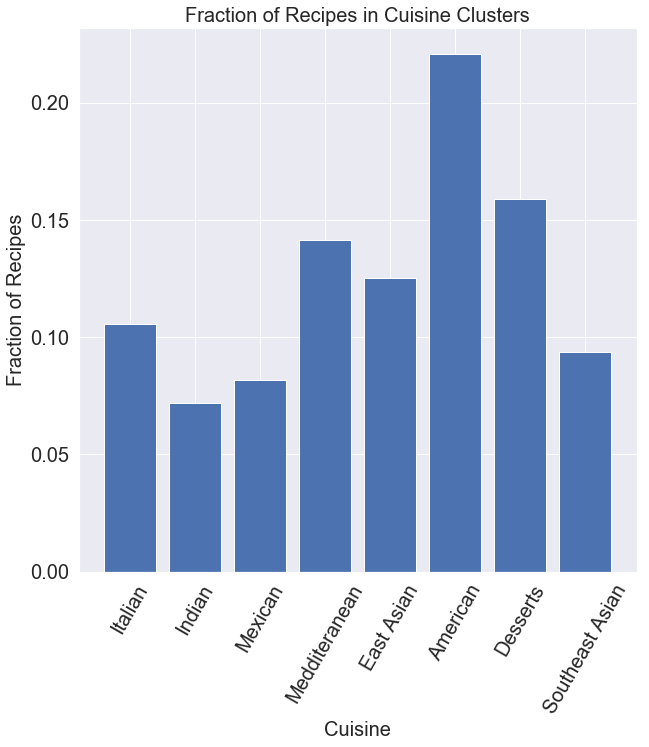

In [387]:
cluster_sizes = [ y[1]/total_recipes for y in sorted(Counter(assignment).items(), key=lambda x: x[0]) ]

plt.figure(figsize=(10,10))
plt.bar(x=range(8), height=cluster_sizes, tick_label=['Italian', 'Indian', 'Mexican', 'Medditeranean', 'East Asian', 'American', 'Desserts', 'Southeast Asian'])
plt.xticks(rotation=60, fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Cuisine', fontsize=20)
plt.ylabel('Fraction of Recipes', fontsize=20)
plt.title('Fraction of Recipes in Cuisine Clusters', fontsize=20);
plt.savefig('FractionRecipesInCuisine.png', dpi=300, bbox_inches='tight')

## PCA

We can visualize our clusters by fitting a PCA to the data and project our data onto a 2D grid by using only the first two components.

In [360]:
pca = PCA(n_components=2)
ingredient_counts_pca = pca.fit_transform(ingredient_counts_tfidf_df)

With just two components, how much of the variance explained?

In [361]:
pca.explained_variance_ratio_.sum()

0.053344228799964005

Let's now visualize our clusters.

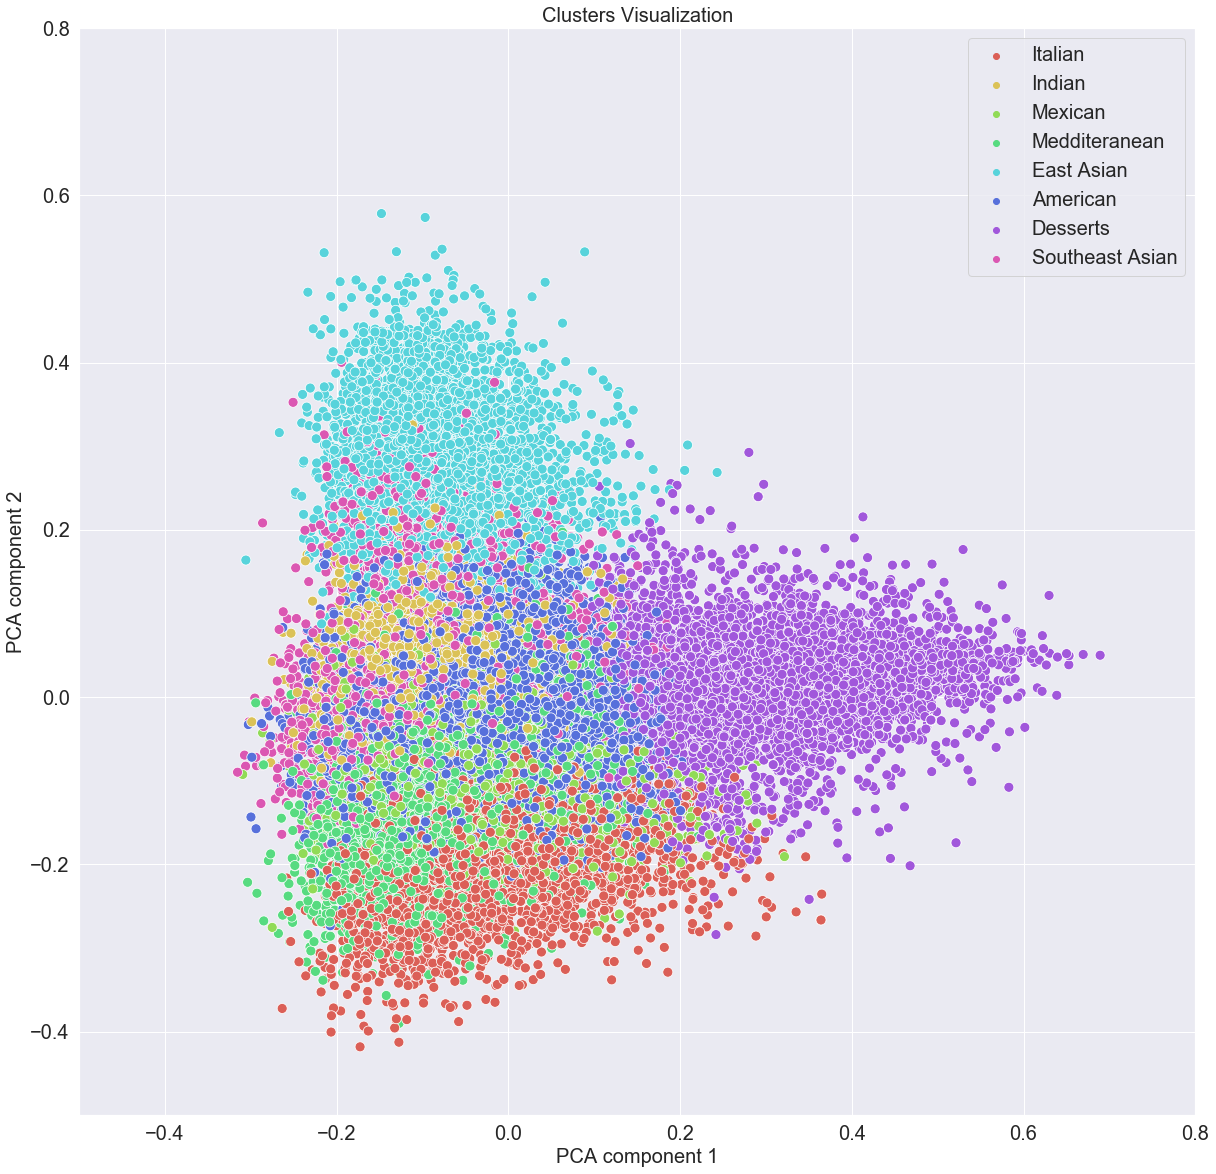

In [388]:
sns.set()
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(20,20))  
ax = sns.scatterplot(x=[ item[0] for item in ingredient_counts_pca], y=[ item[1] for item in ingredient_counts_pca],
               hue=assignment, palette=sns.color_palette("hls", n_colors=8), s=100)
leg_handles = ax.get_legend_handles_labels()[0]
plt.legend(leg_handles, ['Italian', 'Indian', 'Mexican', 'Medditeranean', 'East Asian', 'American', 'Desserts', 'Southeast Asian'], prop={'size':20})
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('PCA component 1', fontsize=20)
plt.ylabel('PCA component 2', fontsize=20)
plt.xlim(-0.5,0.8)
plt.ylim(-0.5,0.8)
plt.title('Clusters Visualization', fontsize=20);
plt.savefig('ClustersVisualization.png', dpi=300, bbox_inches='tight')

In [375]:
cluster_centers = kmeans.cluster_centers_
cluster_centers_pca = pca.fit_transform(cluster_centers)

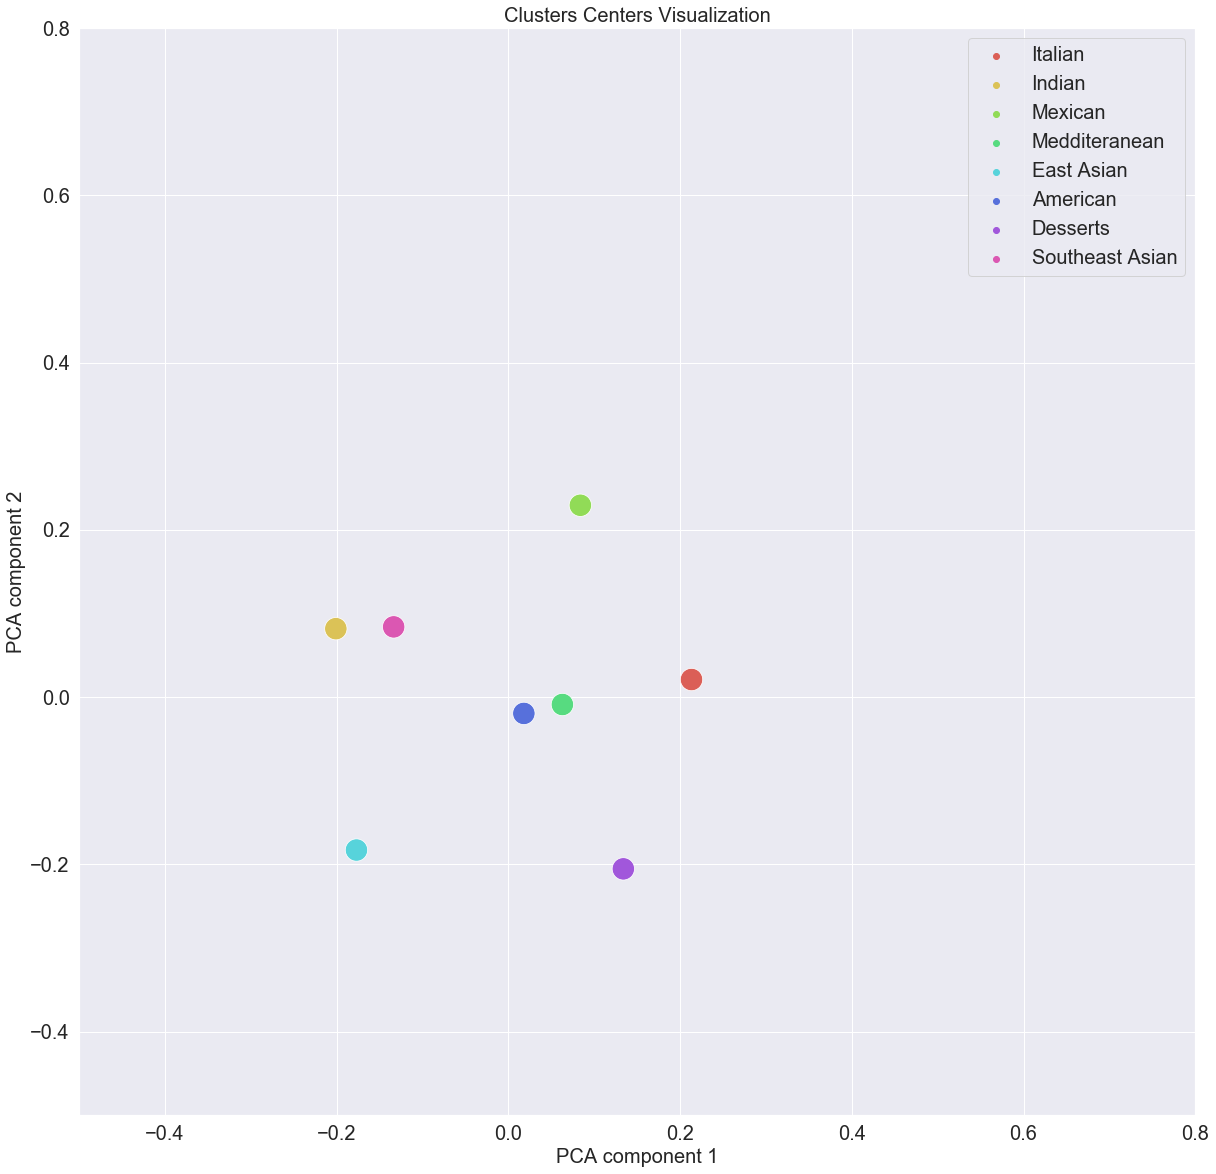

In [381]:
sns.set()
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(20,20))  
ax = sns.scatterplot(x=[ item[0] for item in cluster_centers_pca], y=[ item[1] for item in cluster_centers_pca],
               hue=range(8), palette=sns.color_palette("hls", n_colors=8), s=500)
leg_handles = ax.get_legend_handles_labels()[0]
plt.legend(leg_handles, ['Italian', 'Indian', 'Mexican', 'Medditeranean', 'East Asian', 'American', 'Desserts', 'Southeast Asian'], prop={'size':20})
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('PCA component 1', fontsize=20)
plt.ylabel('PCA component 2', fontsize=20)
plt.xlim(-0.5,0.8)
plt.ylim(-0.5,0.8)
plt.title('Clusters Centers Visualization', fontsize=20);

# Distinguishing ingredients in each cuisine

Here we determine the distinguishing ingredients of each cuisine. The metric we will use to evaluate the importance of a particular ingredient in a particular cuisine is the fraction of recipes that utilize that ingredient in that cuisine minus the fraction of recipes that utilize that ingredient in the cuisine that utilizes it the second most commonly.

First we calculate the fraction of recipes that utilize each ingredient in each cuisine

In [390]:
cuisines = ['Italian', 'Indian', 'Mexican', 'Medditeranean', 'East Asian', 'American', 'Desserts', 'Southeast Asian']
cuisine_ingredients = {}
for index in range(8):
    recipes_in_cluster = ingredient_counts_cv_df[assignment == index]
    cuisine_ingredients[cuisines[index]] = recipes_in_cluster.sum().sort_values(ascending=False) / len(recipes_in_cluster)

In [393]:
cuisine_ingredients['Italian'][:20]

cheese        0.949322
parmesan      0.639305
garlic        0.531763
olive         0.498929
tomatoes      0.309779
basil         0.306686
mozzarella    0.298834
sauce         0.257435
butter        0.246491
onions        0.218415
cloves        0.213657
chicken       0.211516
eggs          0.210802
pasta         0.192482
parsley       0.189151
italian       0.168689
onion         0.162027
bread         0.148941
flour         0.142755
oregano       0.137045
dtype: float64

Now we can calculate evaluation metric.

In [469]:
def frac_recip_with_ingred_in_cuisine(ingredient, cuisine, cuisine_dict):
    '''Function to check whether an ingredient is used in a certain cuisine.
    
    Returns: fraction of recipes that utilize an ingredient in a cuisine, or 0 if it is not used.'''
    if ingredient in cuisine_dict[cuisine]:
        return cuisine_dict[cuisine][ingredient]
    else:
        return 0

The following code does the following:
 - 1) Choose a cuisine (cuisine1).
 - 2) Loop through each ingredient within that cuisine.
 - 3) For a given ingredient, loop through all other cuisines except cuisine1 and find the fraction of recipes that utilize the ingredient within those cuisines. These values are appended to a list (ingredient_counts).
 - 4) Take the maximum value of the list and subtract it from the fraction of recipes that utilize the ingredient in cuisine1.
 
Once this is completed for all ingredients within cuisine1, the results are added to a dictionary. Each key of the dictionary is a cuisines and its corresponding value is a dictionary whose keys are ingredients and values are the results of step 4.

In [455]:
cuisine_differences = {}
for cuisine1 in cuisine_ingredients.keys():
    difference = {}
    for ingredient in cuisine_ingredients[cuisine1].keys():
        ingredient_counts = []
        for cuisine2 in cuisine_ingredients.keys():
            if cuisine1 != cuisine2:
                ingredient_counts.append(frac_recip_with_ingred_in_cuisine(ingredient, cuisine2, cuisine_ingredients))
        try:
            ingredient_max = max(ingredient_counts)
        except:
            ingredient_max = 0
        difference[ingredient] = cuisine_ingredients[cuisine1][ingredient] - ingredient_max
    cuisine_differences[cuisine1] = difference

Let's take a look at the top 15 results for each cuisine.

In [474]:
for cuisine in cuisine_differences.keys():
    print(cuisine)
    print('-------')
    for item in sorted(cuisine_differences[cuisine].items(), key=lambda x: x[1], reverse=True)[:15]:
        print(item[0], item[1])
    print('\n')

Italian
-------
parmesan 0.6165739493228002
mozzarella 0.2797572429949303
cheese 0.18316806676549713
pasta 0.16371224805682727
basil 0.16319431372496826
italian 0.1283764761477043
ricotta 0.11892600711518875
skim 0.07010926261461593
spinach 0.06474367537420064
lasagna 0.06033821995278098
pizza 0.051841601332280225
crumbs 0.047875588269332456
marinara 0.044153965170120386
bread 0.040079573777818844
penne 0.03777105198344385


Indian
-------
coriander 0.43910971824599265
cumin 0.34970348087666525
masala 0.3411164130276995
garam 0.31567566263148994
turmeric 0.2867948292969095
seed 0.2850009428216107
tumeric 0.20404343264886482
cardamom 0.13809801929913662
seeds 0.13050121033491532
curry 0.130096848731007
mustard 0.12265017872928094
cinnamon 0.12182629672974582
yogurt 0.12012438129310116
clove 0.10783043614600832
plain 0.09442649104599554


Mexican
-------
tortillas 0.4185709163592903
sour 0.37624688355123137
cheddar 0.35476338030636106
salsa 0.31138733540769437
beans 0.26115930680623956
j

# EXTRA WORK - NON EDITED

# Clustering using K-means and Binary CountVectorizer

Now that we have a way to clean our data, we can continue on and try to cluster our data using K-means. First we will fit a new CounterVectorizer using our composed list of stop words.

## Binary CountVectorizer

In this implementation, we only care about whether or not the ingredient appears in the recipe (i.e. we don't care if it's mentioned multiple times). To do this, we call CountVectorizer with the option binary=True.

In [220]:
ingredient_cv = CountVectorizer(stop_words=stop_words, binary=True)
ingredient_counts = ingredient_cv.fit_transform(ingredients)

We'll need ingredient_counts (which is currently a CSR matrix) as a dataframe for the next analysis. Let's convert and check the shape.

In [221]:
df = pd.DataFrame(ingredient_counts.toarray(), columns=ingredient_cv.get_feature_names())
df.shape

(39774, 381)

## Clustering with K-means

Now that we have a CountVectorizer matrix, we can do clustering (unsupervised learning) to identify our cuisines. We'll do this first by using K-means. But how many clusters should we use? Let's arbitrarily use K=10 and see if the results make sense.

In [89]:
kmeans = KMeans(n_clusters = 10, random_state = 42, n_init=1)
kmeans.fit(df)
assignment = kmeans.predict(df) # cluster each recipe belongs to

Let's see what the 20 most common ingredients in the 10 clusters are. 

In [90]:
for index in range(10):
    print(df[assignment == index].sum().sort_values(ascending=False)[:20])

cheese        4984
olive         2803
garlic        2800
parmesan      2740
tomatoes      1598
basil         1288
butter        1228
cloves        1205
mozzarella    1173
sauce         1112
parsley       1093
onions        1074
chicken       1054
eggs           996
onion          984
bread          777
oregano        770
pasta          765
wine           723
italian        705
dtype: int64
sauce       1545
fish        1322
lime        1151
garlic      1113
sugar       1070
cilantro     822
juice        777
rice         739
chicken      592
onions       589
ginger       569
coconut      557
milk         511
thai         488
chili        446
cloves       426
basil        399
soy          392
curry        379
peanuts      359
dtype: int64
garlic       1594
cilantro     1549
lime         1343
cumin        1104
onion        1092
juice        1032
olive         845
tomatoes      801
chicken       759
corn          691
cloves        670
onions        606
chili         592
tortillas     577
av

## PCA

In [125]:
pca = PCA(n_components=2)

In [126]:
ingredient_counts_pca = pca.fit_transform(df)

In [127]:
pca.explained_variance_ratio_.sum()

0.11237022091914521

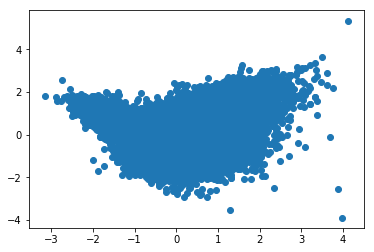

In [128]:
plt.scatter(x=[ item[0] for item in ingredient_counts_pca], y=[ item[1] for item in ingredient_counts_pca])

In [21]:
ingredient_counts_pca[0]

array([-0.34095317, -0.20730138])

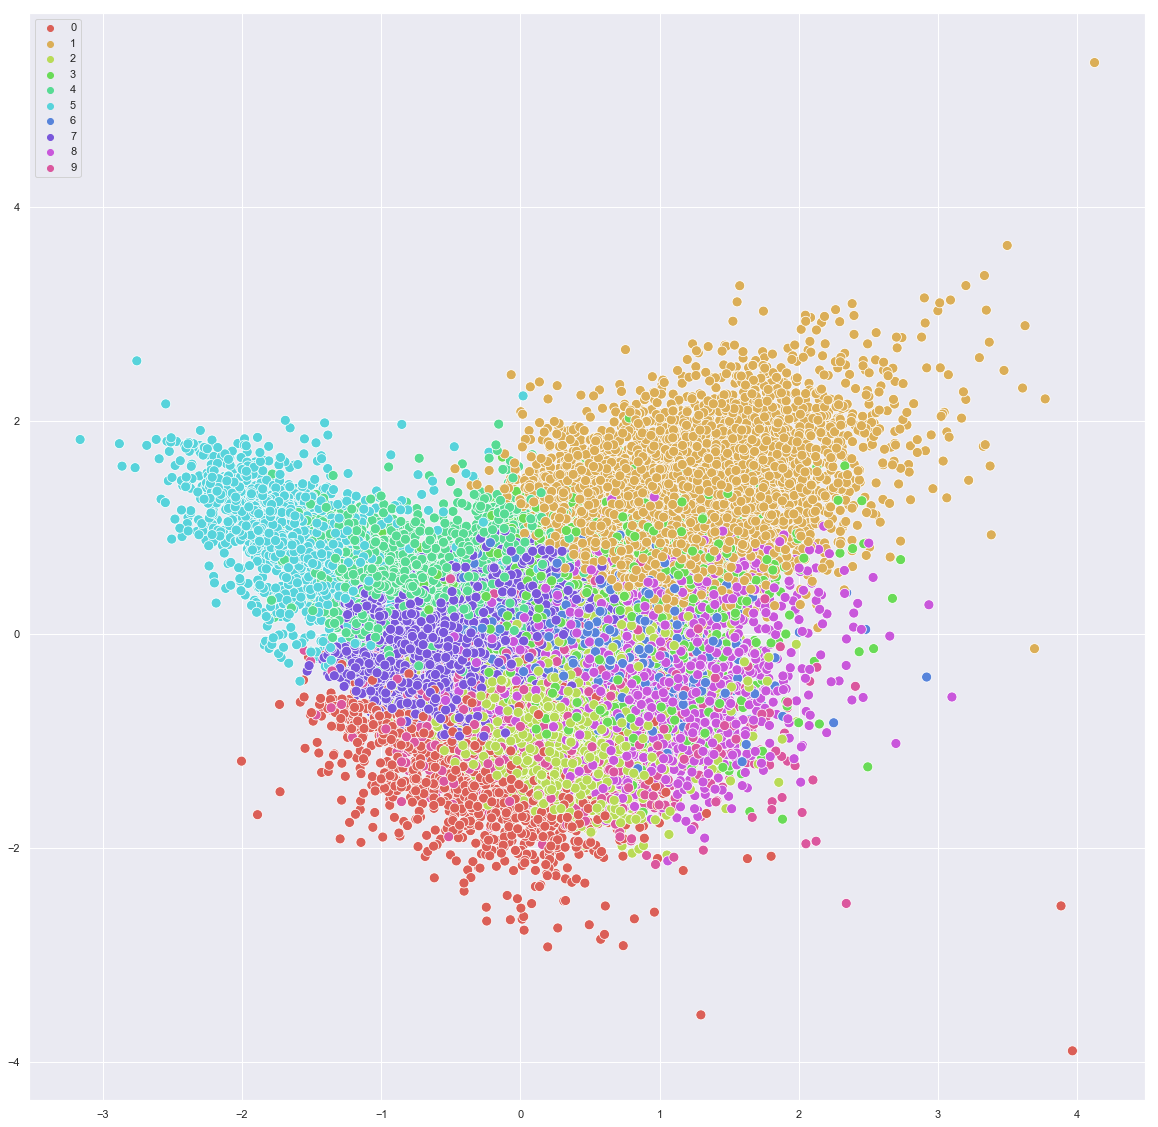

In [169]:
sns.set()
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(20,20))  
sns.scatterplot(x=[ item[0] for item in ingredient_counts_pca], y=[ item[1] for item in ingredient_counts_pca],
               hue=assignment, palette=sns.color_palette("hls", n_colors=10), s=100)

# Gaussian mixture model (on tfidf)

In [247]:
from sklearn.mixture import GaussianMixture

In [248]:
gmm = GaussianMixture(n_components=10, random_state=42)

In [249]:
gmm.fit(df)
assignment = gmm.predict(df) # cluster each recipe belongs to

In [280]:
gmm.converged_

True

In [250]:
for index in range(10):
    print(df[assignment == index].sum().sort_values(ascending=False)[:20])

cheese        800.042767
olive         743.698228
parmesan      635.733743
garlic        555.690784
basil         469.310401
parsley       461.723118
tomatoes      434.235268
cloves        400.323726
butter        376.995735
mozzarella    366.960656
wine          333.940371
chicken       294.001777
pasta         288.924497
bread         288.406942
dry           286.614095
italian       273.694157
onions        270.717038
oregano       257.872654
onion         253.388982
eggs          252.080513
dtype: float64
cumin        453.392781
garlic       424.612563
onions       374.662707
ginger       365.322514
coriander    354.633915
masala       284.577209
tomatoes     280.263358
chili        273.206861
cilantro     271.399600
turmeric     263.090306
garam        261.821679
lemon        259.376098
curry        259.289990
chicken      257.931466
olive        257.427317
cloves       247.469724
seed         246.870075
cinnamon     237.771778
seeds        233.011865
juice        230.825451
dtype

Italian, Indian, Mexican, Medditeranean, Thai, Creole, Desserts, Chinese, Mexican2,  ?

<BarContainer object of 10 artists>

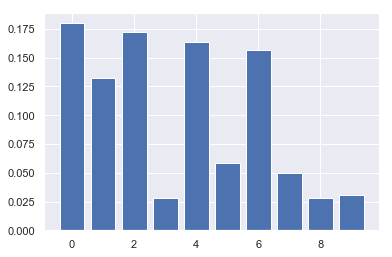

In [274]:
from collections import Counter

cluster_fractions = [ y[1]/total_recipes for y in sorted(Counter(assignment).items(), key=lambda x: x[0]) ]
plt.bar(x=range(10), height=cluster_fractions)

In [311]:
gmm.predict_proba(df)[1030]

array([0.00000000e+000, 1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 3.69835274e-299])